# Sequence to Sequence with Attention
Those are the models that are used on Machine translation. Different than the many-to-many approach, the sequence to sequence can output a sequence with size different than the input sequence.
This example we're going to learn about the encoder/decoder architecture with attention.

### Encoder / Decoder architecture.
On the previous architecture we give to the decoder only the hidden vector of the last word of the sequence (Context Vector), now with attention, we must store all the hidden states of the encoder and feed to the attention decoder module.

![alt text](imgs/seq_to_seq_attn_anim.gif "Sequence to Sequence")
With the attention module each timestep of the output has access to the whole encoder hidden states, so with the aid of weights the decoder can give attention to any part of the input text. 

![alt text](imgs/RNN_SEQ_2_SEQ_ATTN_TRAIN.png "Sequence to Sequence")

### Words Representation
The words will be converted to an index value. Those index sequence will be fed to both encoder and decoder.
Internally the encoder and decoder has an embedding layer that will learn from your data the best vector to represent each word. (sort of automatic word2vec)
![alt text](imgs/embedding_RNN.png "Sequence to Sequence")


### References
* https://towardsdatascience.com/transformers-141e32e69591
* https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
* https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
* http://nlp.seas.harvard.edu/2018/04/03/attention.html
* https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/
* https://github.com/harvardnlp/annotated-transformer
* https://arxiv.org/pdf/1902.10525.pdf
* https://distill.pub/2017/ctc/
* https://distill.pub/2019/memorization-in-rnns/
* https://jalammar.github.io/illustrated-word2vec/
* https://www.youtube.com/watch?v=quoGRI-1l0A
* https://www.youtube.com/watch?v=SysgYptB198
* https://medium.com/synapse-dev/understanding-bert-transformer-attention-isnt-all-you-need-5839ebd396db
* https://www.youtube.com/watch?v=0EtD5ybnh_s
* https://discuss.pytorch.org/t/detach-no-grad-and-requires-grad/16915/3
* https://medium.com/datadriveninvestor/attention-in-rnns-321fbcd64f05
* https://github.com/zhedongzheng/finch#text-generation

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import time
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
#from torchsummary import summary
from tensorboardX import SummaryWriter

from utils_seq_to_seq import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Compute device:',device)

SOS_token = 0
EOS_token = 1
MAX_LENGTH = 10
hidden_size = 256
teacher_forcing_ratio = 0.5

# Writer for Tensorboard X
writer = SummaryWriter('./logs')

Compute device: cpu


### Load the dataset

In [2]:
# Convert to lowercase and simplify expressions
print(normalizeString('Hi hello world! What\'s your name?'))
# Load dataset
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
# Get some X-Y data
print(random.choice(pairs))

hi hello world ! what s your name ?
Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['j essaie quelque chose de nouveau .', 'i m trying something new .']


### Encoder
The encoder input will be input sequence word index, and the previous output (hidden state). The Encoder has an embedding layer so it will automatically learn an embedding based on your data.
![alt text](imgs/Encoder.png "Sequence to Sequence")
#### Shapes
```
    Input shape: torch.Size([1])
    Hidden shape: torch.Size([1, 1, 256])
```

In [3]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        input = input.type(torch.LongTensor)
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Decoder
We will pull out of the decoder the output sequece, starting by giving the encoder accumulated hidden_vector and the SOS(start of sequence) input. 

After that the decoder will receive the last decoded word and it's own hidden state.
![alt text](imgs/ATTN_CELL.png "Sequence to Sequence")

#### Shapes
```
Input shape: torch.Size([1, 1])
Hidden shape: torch.Size([1, 1, 256])
```

### Attention Decoder Module

In [4]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        # Apply Embedding layer on the input(Learn word2vec from your data)
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # How much attention to give for each element of the input sequence 
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        # Matrix (batch,n,m) multiplication between attention weights and encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))

        # Merge the input sequence element the context (Attention applied to the encoder output)
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        # Send all to the GRU cell
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        
        # Get probabilities from the output
        output = F.log_softmax(self.out(output[0]), dim=1)
        
        # We return attn_weights just for debugging
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Training Functions
On this step we will do the backpropagation trough time to train our sequence to sequence model. Observe that we calculate the loss for each time step of the target sequence.

#### Teacher Forcing
It's a technique used to make the sequence to sequence model converge faster, by giving the target word to the decoder input instead of the decoder previous word guess.

In [5]:
def train(input_tensor, target_tensor, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # Start encoder hidden state as zero
    encoder_hidden = encoder.initHidden()

    # Zero the gradient for doing backprop
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Get input/output sequence lenghts (the sequences has indexes of words not words....)
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)  
    
    # Tensor to hold the encoder outputs to be given to the attention module
    # Observe that we need to have a "max_length" because the attention module is finite
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    # Initialize Loss
    loss = 0

    # Push input sequence into encoder and accumulate into encoder_hidden
    # Imagine it's reading the text and memorizing....
    for ei in range(input_length):
        # Push the sequence element on the encoder
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        # Store the encoder output (Will be given to the attention module)
        encoder_outputs[ei] = encoder_output[0, 0]

    # Prepare Decoder input (SOS(Start of sequence) and encoder hidden state)
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    # Roll the dice to decide if we should use teacher_forcing
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # Run one decoder timestep
            decoder_output, decoder_hidden, _ = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            # Push into the decoder the last target word (Teacher forcing) 
            decoder_input = target_tensor[di]
            
            # Calculate the loss
            loss += criterion(decoder_output, target_tensor[di])

    else:
        # Without teacher forcing: use its own predictions (Decoder guess) as the next input
        for di in range(target_length):
            # Run one decoder timestep
            decoder_output, decoder_hidden, _ = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            # Push into the decoder the top1 decoded word
            topv, topi = decoder_output.topk(1)
            # Put the last word guessed by the decoder as next decoder input)
            # detach is useful when you want to compute something that you don’t want to differentiate.             
            decoder_input = topi.squeeze().detach()  

            # Calculate the loss
            loss += criterion(decoder_output, target_tensor[di])
            
            # Or finsh when the input is EOS
            if decoder_input.item() == EOS_token:
                break

    # Calculate the loss gradient wrt to the model weights
    loss.backward()

    # Do the gradient descent step
    encoder_optimizer.step()
    decoder_optimizer.step()

    # Return normalized loss
    return loss.item() / target_length

In [6]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    # Initialize SGD Optimizer to train the network
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    # Load #n_iters pairs from the dataset (ie: je suis --> I am) (Data on index format)
    training_pairs = [tensorsFromPair(random.choice(pairs), input_lang, output_lang, device)
                      for i in range(n_iters)]
    
    # negative log likelihood loss.
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        # Select a sample
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        # Convert sample index list to string to log on tensorboard
        target_string_list = [output_lang.index2word[index.item()] for index in target_tensor]
        input_string_list = [input_lang.index2word[index.item()] for index in input_tensor]        
        writer.add_text('data/Sample', ' '.join(input_string_list) + ' --> ' + ' '.join(target_string_list), iter)        

        # Train on that particular input/output sequence
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        
        # Accumulate Loss for display
        print_loss_total += loss
        plot_loss_total += loss
        
        # Send loss to Tensorboard
        writer.add_scalar('loss/train', loss, iter)

        # Log some information
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
        # Log some information
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    # Display loss plot
    showPlot(plot_losses)

### Evaluate Functions
With the model trained we do the following....
1. Push input sequence (list of indexes) into the Encoder
2. Accumulate all into encoder hidden state
3. Start Decoder with <SOS> and encoder hidden state
4. Push into decoder the last hidden state and the previous most probable word (index) (top1)
    
![alt text](imgs/seq_2_seq_simple_eval.png "Sequence to Sequence")

In [7]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence, device)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden() 
        
        # Tensor to hold the encoder outputs to be given to the attention module
        # Observe that we need to have a "max_length" because the attention module is finite
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        # Tensor to help display which parts of the sentence the attention decoder is focusing
        decoder_attentions = torch.zeros(max_length, max_length)

        # Push input sequence into encoder and accumulate into encoder_hidden
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)  
            # Store the encoder output (Will be given to the attention module)
            encoder_outputs[ei] = encoder_output[0, 0]

        # Prepare Decoder input (SOS(Start of sequence) and encoder hidden state)
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden

        # List with output words
        decoded_words = []

        # Pull the sequence out of the decoder and append results into decoded_words
        for di in range(max_length):
            # Push into the decoder the last hidden state and the top1 last decoded word
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            
            # Get first topk results (Greedy most probable word from output)
            topv, topi = decoder_output.data.topk(1)
            
            # Append more words to the output or finish (received EOS)
            if topi.item() == EOS_token:
                # Stop if End of sequence <EOS>
                decoded_words.append('<EOS>')
                break
            else:
                # Append word to decoded_words
                decoded_words.append(output_lang.index2word[topi.item()])

            # Put back to the input the word with highest score
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


def evaluateAndShowAttention(input_sentence, encoder, decoder_attn):
    output_words, attentions = evaluate(
        encoder, decoder_attn, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

### Train and Evaluate

3m 12s (- 44m 53s) (5000 6%) 2.8275
6m 20s (- 41m 12s) (10000 13%) 2.2837
9m 29s (- 37m 56s) (15000 20%) 1.9971
12m 39s (- 34m 48s) (20000 26%) 1.7639
15m 54s (- 31m 48s) (25000 33%) 1.5534
19m 12s (- 28m 48s) (30000 40%) 1.3731
22m 28s (- 25m 41s) (35000 46%) 1.2183
25m 44s (- 22m 31s) (40000 53%) 1.0920
29m 7s (- 19m 25s) (45000 60%) 0.9721
32m 29s (- 16m 14s) (50000 66%) 0.8831
35m 55s (- 13m 3s) (55000 73%) 0.7937
39m 4s (- 9m 46s) (60000 80%) 0.7343
42m 15s (- 6m 30s) (65000 86%) 0.6860
45m 27s (- 3m 14s) (70000 93%) 0.6416
48m 38s (- 0m 0s) (75000 100%) 0.5721
> nous avons termine .
= we re done .
< we re done . <EOS>

> elle demande comment c est possible .
= she s asking how that s possible .
< she s asking you s it . <EOS>

> je ne suis pas content .
= i m not happy .
< i m not happy . <EOS>

> nous allons commencer .
= we re going to begin .
< we re going to die . <EOS>

> vous etes plus grand qu elle .
= you are taller than she is .
< you are taller than she is . <EOS>

> je

<Figure size 432x288 with 0 Axes>

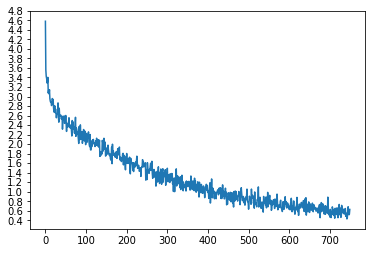

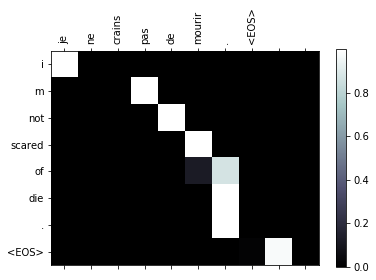

In [8]:
# Instantiate Encoder and Decoder Networks
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

# Push Graphs to Tensorboard
encoder_dummy_x = (torch.rand(1).type(torch.LongTensor), torch.rand(1, 1, 256))
decoder_dummy_x = (torch.rand(1,1).type(torch.LongTensor), torch.rand(1, 1, 256), torch.rand(10, 256))
#writer.add_graph(encoder1, encoder_dummy_x)
# Multiple graphs are not supported at the moment on tensorboard
writer.add_graph(decoder1, decoder_dummy_x)

# Train
trainIters(encoder1, decoder1, 75000, print_every=5000)

# Evaluate
evaluateRandomly(encoder1, decoder1)

# Try to understand how the decoder attend to certain parts of the input
evaluateAndShowAttention("je ne crains pas de mourir .", encoder1, decoder1)